In [2]:
#Import libraries and functions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`

In [3]:
#Import data frame
df = pd.read_csv('CarPriceData.csv')


## Data Preparation
* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [4]:
#Trim Data Frame
#Trim columns
ColsToKeep = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']
df_Trim = df[ColsToKeep]

#Lowercase the column names
df_Trim.columns = df_Trim.columns.str.lower()
#Replace spaces with underscores
df_Trim.columns = df_Trim.columns.str.replace(' ','_')

#Fill missing with 0
df_Trim = df_Trim.fillna(0)

#Make the price binary (1 if above average, 0 otherwise)
AvPrice = df_Trim['msrp'].mean()
y = df_Trim['msrp'].where(df_Trim['msrp'] < AvPrice,1)
y = y.where(df_Trim['msrp'] >= AvPrice,0)
df_Trim = df_Trim.drop(['msrp'], axis=1) #removing msrp otherwise the model will train on it

#Split data into 3 parts (train/validation/test - 60/20/20)
X_train, X_test_val, y_train, y_test_val = train_test_split(df_Trim, y, test_size=0.4, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=1)

print("Size of Training Dataset: ",len(X_train))
print("Size of Test Dataset: ",len(X_test))
print("Size of Validation Dataset: ",len(X_val))

Size of Training Dataset:  7148
Size of Test Dataset:  2383
Size of Validation Dataset:  2383


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

{'engine_hp': 0.9159001518508375,
 'engine_cylinders': 0.768274900593613,
 'highway_mpg': 0.6333685399678282,
 'city_mpg': 0.67232674562278}

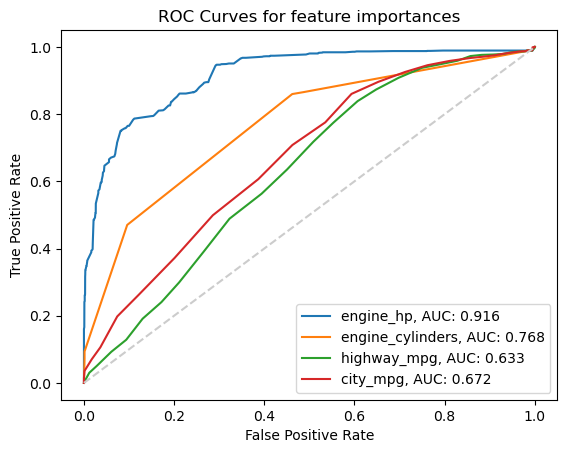

In [5]:
Cols = ['engine_hp','engine_cylinders','highway_mpg','city_mpg']
from sklearn.metrics import roc_curve
#MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X_train[Cols])
df_Scaled = pd.DataFrame(x_scaled,columns=Cols)

#Initial run showed that highway and city mpg are negatively correlated so flip them
df_Scaled['highway_mpg'] = -df_Scaled['highway_mpg']
df_Scaled['city_mpg'] = -df_Scaled['city_mpg']

#Now calculate the ROC AUC
ResultDict = {}
for col in Cols:
    auc = roc_auc_score(y_train, df_Scaled[col])
    ResultDict[col] = roc_auc_score(y_train, df_Scaled[col])
    labn = col + ", AUC: " + str(round(auc,3))
    fpr, tpr, thresh = roc_curve(y_train, df_Scaled[col])
    plt.plot(fpr,tpr, label=labn)

display(ResultDict)

# Now plot the ROCs for a demo
plt.title("ROC Curves for feature importances")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

Midline=np.arange(0,1.01,0.01)
plt.plot(Midline,Midline,'--', color=[0.8,0.8,0.8])

`engine_hp` has the highest correlation if you use the scaling I have here

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [6]:
#Fit the DictVectorizer
dv = DictVectorizer(sparse=False)
d = df_Trim.to_dict(orient='records')
#d = X_train.to_dict(orient='records')
dv.fit(d)

#For training data set
d = X_train.to_dict(orient='records')
X_train_dv = dv.transform(d)

#For test data set
d = X_test.to_dict(orient='records')
X_test_dv = dv.transform(d)

#For test data set
d = X_val.to_dict(orient='records')
X_val_dv = dv.transform(d)

In [7]:
# Now logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_dv,y_train)

y_pred_test_soft = model.predict_proba(X_test_dv)[:,1] #probabilities they are above average (1)

#AUC Score
ROCscore = roc_auc_score(y_test,y_pred_test_soft)
print("y_pred_test_soft ROC: ", round(ROCscore,5))

y_pred_test_soft ROC:  0.97985


Text(0, 0.5, 'True Positive Rate')

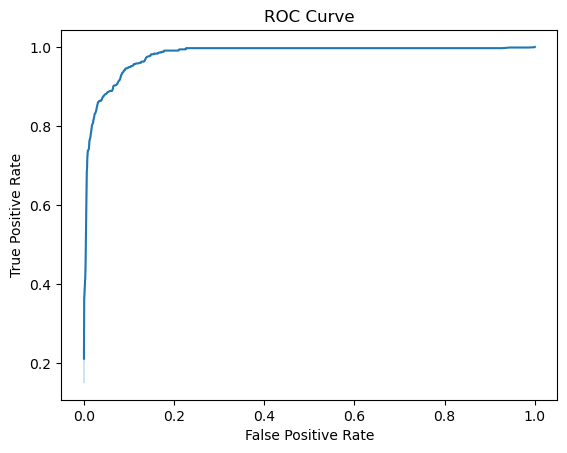

In [8]:
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(y_test, y_pred_test_soft)
fig1 = sns.lineplot(x=fpr, y=tpr)
fig1.set_title("ROC Curve")
fig1.set_xlabel('False Positive Rate')
fig1.set_ylabel('True Positive Rate')

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

/Users/marcusleiwe/anaconda3/envs/ml-zoomcamp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

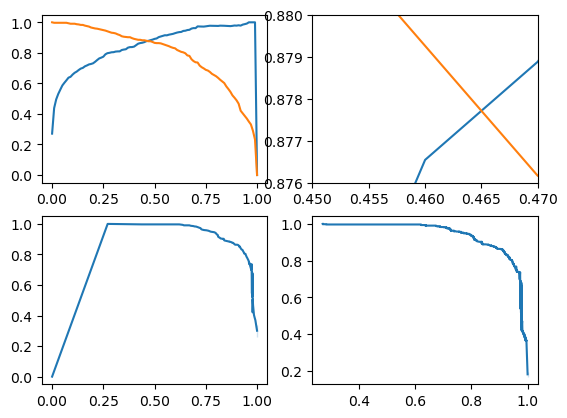

In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import precision_recall_curve

nVals = len(np.arange(0,1.01,0.01))
PrecisionResults = np.zeros(nVals)
RecallResults = np.zeros(nVals)

c = 0
for th in np.arange(0,1.01,0.01):
    y_pred = (y_pred_test_soft > th).astype(int)
    Pres = precision_score(y_test,y_pred)
    Recall = recall_score(y_test, y_pred)
    PrecisionResults[c] = Pres
    RecallResults[c] = Recall
    c += 1

#print("Precision Values: \n", PrecisionResults)
#print("\nRecall Values: \n", RecallResults)

fig,ax = plt.subplots(2,2)
#Visualise the intersect
ax[0,0].plot(np.arange(0,1.01,0.01), PrecisionResults, color='tab:blue')
ax[0,0].plot(np.arange(0,1.01,0.01), RecallResults, color='tab:orange')

ax[0,1].plot(np.arange(0,1.01,0.01), PrecisionResults, color='tab:blue')
ax[0,1].plot(np.arange(0,1.01,0.01), RecallResults, color='tab:orange')
ax[0,1].set_xlim(0.45,0.47)
ax[0,1].set_ylim(0.876,0.88)

#PR curves
sns.lineplot(x=PrecisionResults, y=RecallResults, ax=ax[1,0])

precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_pred_test_soft)
sns.lineplot(x=precision2, y=recall2, ax=ax[1,1])


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

Maximum F1 Score:  0.8841269841269841

Best Threshold:  0.53


/Users/marcusleiwe/anaconda3/envs/ml-zoomcamp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/6f/d2f9mt417y32sjcfd4zvfwdh0000gn/T/ipykernel_76322/3114508009.py:9: RuntimeWarning: invalid value encountered in scalar divide
  F1score = ((Pres * Recall) / (Pres + Recall)) *2


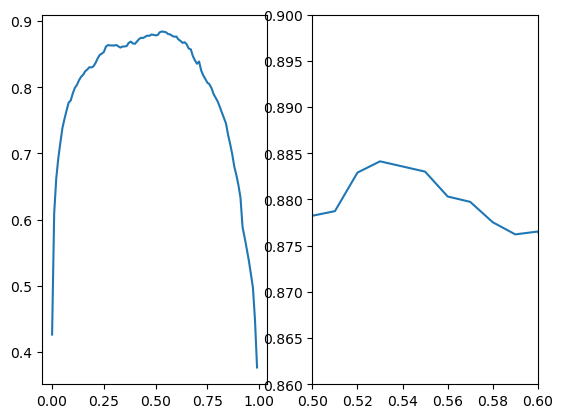

In [10]:
F1_Scores = np.zeros(nVals)
Thresh = np.arange(0,1.01,0.01)

c = 0
for th in Thresh:
    y_pred = (y_pred_test_soft > th).astype(int)
    Pres = precision_score(y_test,y_pred)
    Recall = recall_score(y_test, y_pred)
    F1score = ((Pres * Recall) / (Pres + Recall)) *2
    F1_Scores[c] = F1score
    c += 1

fig,ax = plt.subplots(1,2)
sns.lineplot(x=Thresh, y=F1_Scores, ax=ax[0])
sns.lineplot(x=Thresh, y=F1_Scores, ax=ax[1])
ax[1].set_xlim(0.5,0.6)
ax[1].set_ylim(0.86,0.9)

print("Maximum F1 Score: ", np.nanmax(F1_Scores))
print("\nBest Threshold: ", Thresh[np.nanargmax(F1_Scores)])

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [11]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)

AUCscores = np.zeros(5)
fold = 0
for train_idx, val_idx in kf.split(X_train_dv):
    #split the training set and testing sets
    df_train = X_train.iloc[train_idx]
    df_test = X_train.iloc[val_idx]

    y_train_kf = y_train.iloc[train_idx]
    y_test_kf = y_train.iloc[val_idx]

    #Dictionary Vectoriser
    d_train = df_train.to_dict(orient='records')
    d_test = df_test.to_dict(orient='records')

    df_train_dv = dv.transform(d_train)
    df_test_dv = dv.transform(d_test)

    #Instantiate and fit the model
    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000)
    model.fit(df_train_dv, y_train_kf)

    #Predict and calculate the ROC AUC score
    y_pred_kf = model.predict_proba(df_test_dv)[:,1]
    print(roc_auc_score(y_test_kf, y_pred_kf))
    AUCscores[fold] = roc_auc_score(y_test_kf, y_pred_kf)
    
    fold += 1

print("Standard Deviation of ROC-AUC Curve:", np.std(AUCscores))






0.9771626001345318
0.9808349514563107
0.9795043703823327
0.986986301369863
0.9832715000359032
Standard Deviation of ROC-AUC Curve: 0.0033604192768399983


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [12]:
Cvals = [0.01, 0.1, 0.5, 10]
Mean_Cval_AUC = np.zeros(len(Cvals))
counter1 = 0
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for c in Cvals:
    #K fold
    AUCscores = np.zeros(5)
    fold = 0
    for train_idx, val_idx in kf.split(X_train_dv):
        #split the training set and testing sets
        df_train = X_train.iloc[train_idx]
        df_test = X_train.iloc[val_idx]

        y_train_kf = y_train.iloc[train_idx]
        y_test_kf = y_train.iloc[val_idx]

        #Dictionary Vectoriser
        d_train = df_train.to_dict(orient='records')
        d_test = df_test.to_dict(orient='records')

        df_train_dv = dv.transform(d_train)
        df_test_dv = dv.transform(d_test)

        #Instantiate and fit the model
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(df_train_dv, y_train_kf)

        #Predict and calculate the ROC AUC score
        y_pred_kf = model.predict_proba(df_test_dv)[:,1]
        AUCscores[fold] = roc_auc_score(y_test_kf, y_pred_kf)
        
        fold += 1
    MeanAUC = np.mean(AUCscores)
    Mean_Cval_AUC[counter1] = MeanAUC
    counter1 += 1
CvalDict = {'Cval':Cvals,'AUC Score':Mean_Cval_AUC}
temp_df =pd.DataFrame.from_dict(CvalDict)
display(temp_df)

,Cval,AUC Score
0,0.01,0.948740
1,0.10,0.969472
2,0.50,0.977208
3,10.00,0.981552
